In [1]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
random_state = 42

scaler = StandardScaler()


data_ssgsea = pd.read_csv('ssgsea_10.csv')
X_ssgsea = data_ssgsea.iloc[:, 1:]
y_ssgsea = data_ssgsea.iloc[:, 0]  

X_train_ssgsea_raw, X_test_ssgsea_raw, y_train_ssgsea, y_test_ssgsea = train_test_split(X_ssgsea, y_ssgsea, test_size=0.2, random_state = random_state)

X_train_ssgsea = scaler.fit_transform(X_train_ssgsea_raw)
X_test_ssgsea = scaler.transform(X_test_ssgsea_raw)

scaler = StandardScaler()

data_ppi = pd.read_csv('ppi_10.csv')
X_ppi = data_ppi.iloc[:, 1:]
y_ppi = data_ppi.iloc[:, 0]  

X_train_ppi_raw, X_test_ppi_raw, y_train_ppi, y_test_ppi = train_test_split(X_ppi, y_ppi, test_size=0.2, random_state = random_state)

X_train_ppi = scaler.fit_transform(X_train_ppi_raw)
X_test_ppi = scaler.transform(X_test_ppi_raw)

scaler = StandardScaler()

data_wgcna = pd.read_csv('wgcna_10.csv')
X_wgcna = data_wgcna.iloc[:, 1:]
y_wgcna = data_wgcna.iloc[:, 0]  

X_train_wgcna_raw, X_test_wgcna_raw, y_train_wgcna, y_test_wgcna = train_test_split(X_wgcna, y_wgcna, test_size=0.2, random_state = random_state)

X_train_wgcna = scaler.fit_transform(X_train_wgcna_raw)
X_test_wgcna = scaler.transform(X_test_wgcna_raw)



C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import joblib
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load base models
ssgsea = joblib.load('./basemodel/ssgsea/logistic_ssgsea.joblib')
ppi = joblib.load('./basemodel/ppi/rf_ppi.joblib')
wgcna = joblib.load('./basemodel/wgcna/rf_wgcna.joblib')

ssgsea.fit(X_train_ssgsea, y_train_ssgsea.squeeze())
ppi.fit(X_train_ppi, y_train_ppi.squeeze())
wgcna.fit(X_train_wgcna, y_train_wgcna.squeeze())

# Obtain predicted probabilities from each model
pred_ssgsea_train = ssgsea.predict_proba(X_train_ssgsea)[:, 1]
pred_ppi_train = ppi.predict_proba(X_train_ppi)[:, 1]
pred_wgcna_train = wgcna.predict_proba(X_train_wgcna)[:, 1]

pred_ssgsea_test = ssgsea.predict_proba(X_test_ssgsea)[:, 1]
pred_ppi_test = ppi.predict_proba(X_test_ppi)[:, 1]
pred_wgcna_test = wgcna.predict_proba(X_test_wgcna)[:, 1]

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train = np.column_stack((pred_ssgsea_train, pred_ppi_train, pred_wgcna_train))
y_train = y_train_ssgsea.squeeze()

X_test = np.column_stack((pred_ssgsea_test, pred_ppi_test, pred_wgcna_test))
y_test = y_test_ssgsea.squeeze()

# Initialize the logistic regression model
lr_model = LogisticRegression()

# Train the logistic regression model
lr_model.fit(X_train, y_train)

# Save the model
joblib.dump(lr_model, 'meta_model.joblib')

# Predict using the trained model
y_pred_meta = lr_model.predict_proba(X_test)[:, 1]

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_pred_meta)

print(f"AUC score of the logistic regression model: {auc_score}")


AUC score of the logistic regression model: 0.9202898550724637


In [3]:
# Output the coefficients and intercept of the logistic regression model
print("Logistic regression coefficients:", lr_model.coef_)
print("Logistic regression intercept:", lr_model.intercept_)

# Coefficient corresponding to each feature
feature_names = ['ssgsea', 'ppi', 'wgcna']
for feature, coef in zip(feature_names, lr_model.coef_[0]):
    print(f"The coefficient of {feature} is: {coef}")

# Full decision function values
decision_function_values = lr_model.decision_function(X_test)
print("Decision function values of the logistic regression model:", decision_function_values)

import numpy as np

# Calculate odds ratios (ORs) for each feature
odds_ratios = np.exp(lr_model.coef_[0])

# Output the OR for each feature
for feature, odds_ratio in zip(feature_names, odds_ratios):
    print(f"The OR of {feature} is: {odds_ratio}")


Logistic regression coefficients: [[1.22844252 3.75504483 3.44340624]]
Logistic regression intercept: [-4.0342157]
The coefficient of ssgsea is: 1.2284425212597843
The coefficient of ppi is: 3.755044829952833
The coefficient of wgcna is: 3.443406237857911
Decision function values of the logistic regression model: [-0.7750556   1.34184669 -2.25715015 -1.78306235 -0.28054774 -0.8624618
 -1.13964381  0.94566499 -1.04811045  0.1631366  -0.90975869 -0.46575149
 -0.88143129 -3.03389993 -2.34632093 -0.47361117 -0.35795984 -1.9103987
 -1.61939813  1.62101913  0.21477499 -0.84277382  0.18256672 -1.08387861
 -1.42284906 -0.61080842 -0.32703849  0.81550155  0.93607209  0.27058308
 -1.38846695  0.65434375  0.05960407 -0.75938615 -2.05017409]
The OR of ssgsea is: 3.415905191374799
The OR of ppi is: 42.73613562655351
The OR of wgcna is: 31.293369494152703


Model AUC: 0.9203


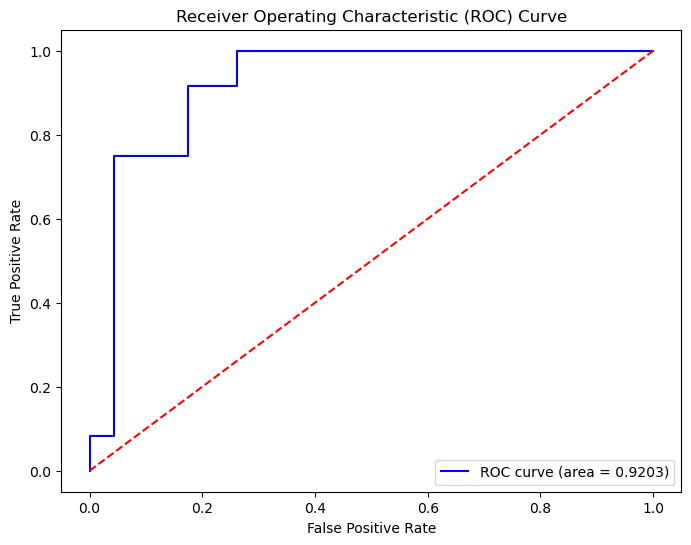

Accuracy: 0.8571428571428571
Precision: 0.8181818181818182
AUC: 0.9202898550724637
Recall: 0.75
F1 score: 0.782608695652174
Confusion Matrix:
 [[21  2]
 [ 3  9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89        23
           1       0.82      0.75      0.78        12

    accuracy                           0.86        35
   macro avg       0.85      0.83      0.84        35
weighted avg       0.86      0.86      0.86        35



In [4]:
import joblib

### Import required libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as ADA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    QuadraticDiscriminantAnalysis,
    LinearDiscriminantAnalysis
)
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Plot feature importance
import matplotlib.pyplot as plt

# Modeling and hyperparameter tuning
np.random.seed(42)

X_val_meta = X_test
y_val_meta = y_test

pred_proba = lr_model.predict_proba(X_val_meta)[:, 1]
y_pred = lr_model.predict(X_val_meta)

# Calculate accuracy
accuracy = accuracy_score(y_val_meta, y_pred)
# Calculate precision
precision = precision_score(y_val_meta, y_pred)
# Calculate AUC
auc = roc_auc_score(y_val_meta, pred_proba)
# Calculate recall
recall = recall_score(y_val_meta, y_pred)
# Calculate F1 score
f1 = f1_score(y_val_meta, y_pred)

# Calculate AUC value
auc_value = roc_auc_score(y_val_meta, pred_proba)
print(f'Model AUC: {auc_value:.4f}')

# Calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_val_meta, pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("AUC:", auc)
print("Recall:", recall)
print("F1 score:", f1)

# Confusion matrix
print("Confusion Matrix:\n", metrics.confusion_matrix(y_val_meta, y_pred))
# Classification report
print("Classification Report:\n", metrics.classification_report(y_val_meta, y_pred))


Model AUC: 0.9203


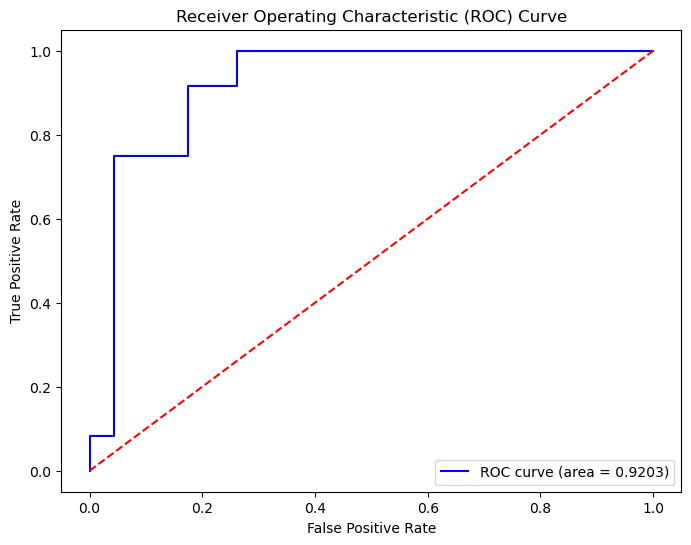

Accuracy: 0.8571428571428571
Precision: 0.8181818181818182
AUC: 0.9202898550724637
Recall: 0.75
F1 score: 0.782608695652174
Confusion Matrix:
 [[21  2]
 [ 3  9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89        23
           1       0.82      0.75      0.78        12

    accuracy                           0.86        35
   macro avg       0.85      0.83      0.84        35
weighted avg       0.86      0.86      0.86        35



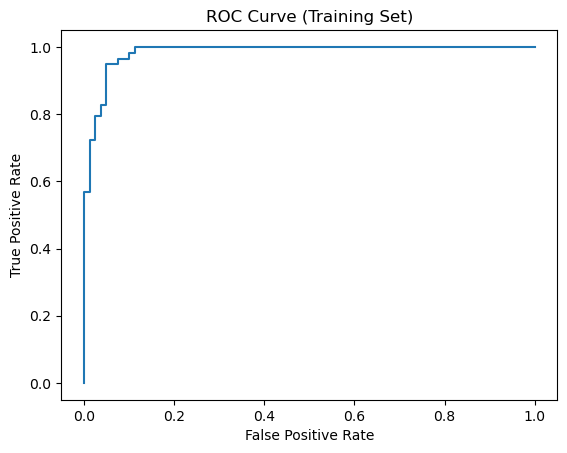

Training accuracy: 0.9492753623188406
Training precision: 0.9322033898305084
Training AUC: 0.984051724137931
Training recall: 0.9482758620689655
Training F1 score: 0.9401709401709402


In [5]:
pred_proba = lr_model.predict_proba(X_test)[:, 1]
y_pred = (pred_proba >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
# Calculate precision
precision = precision_score(y_test, y_pred)
# Calculate AUC
auc = roc_auc_score(y_test, pred_proba)
# Calculate recall
recall = recall_score(y_test, y_pred)
# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate AUC value
auc_value = roc_auc_score(y_test, pred_proba)
print(f'Model AUC: {auc_value:.4f}')

# Calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("AUC:", auc)
print("Recall:", recall)
print("F1 score:", f1)

# Confusion matrix
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred))
# Classification report
print("Classification Report:\n", metrics.classification_report(y_test, y_pred))

# Prediction on the training set
y_pred_proba_train = lr_model.predict_proba(X_train)[:, 1]
y_pred_train = (y_pred_proba_train >= 0.5).astype(int)

# Calculate performance metrics on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
auc_train = roc_auc_score(y_train, y_pred_proba_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# Plot ROC curve for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train)
plt.plot(fpr_train, tpr_train)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Training Set)')
plt.show()

# Output performance metrics on the training set
print("Training accuracy:", accuracy_train)
print("Training precision:", precision_train)
print("Training AUC:", auc_train)
print("Training recall:", recall_train)
print("Training F1 score:", f1_train)


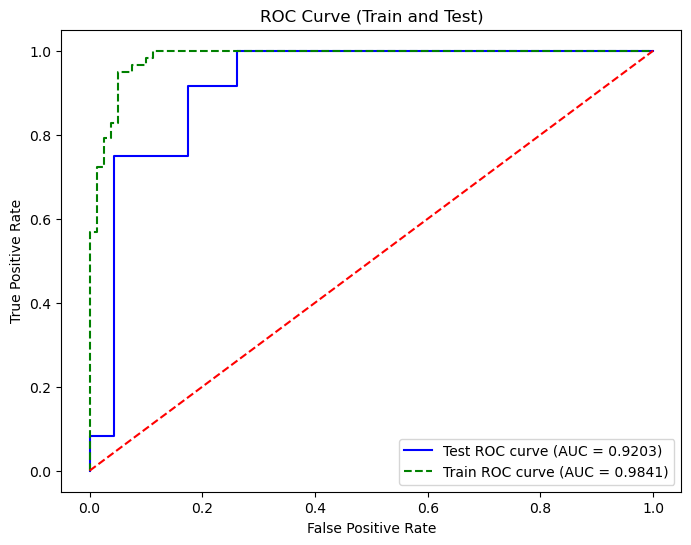

In [6]:
# Plot ROC curves for the training set and the test set
plt.figure(figsize=(8, 6))

# Plot ROC curve for the test set
fpr, tpr, _ = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, color='blue', label=f'Test ROC curve (AUC = {auc_value:.4f})')

# Plot ROC curve for the training set (dashed line)
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
plt.plot(
    fpr_train,
    tpr_train,
    color='green',
    linestyle='--',
    label=f'Train ROC curve (AUC = {auc_train:.4f})'
)

# Diagonal reference line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train and Test)')
plt.legend(loc='lower right')
plt.show()


In [7]:
ssgsea = joblib.load('./basemodel/ssgsea/logistic_ssgsea.joblib')
ppi = joblib.load('./basemodel/ppi/rf_ppi.joblib')
wgcna = joblib.load('./basemodel/wgcna/rf_wgcna.joblib')
meta_model = joblib.load('./meta_model.joblib')

In [8]:
print(ssgsea)
print(ppi)
print(wgcna)
print(meta_model)

LogisticRegression(C=11.599167006256552, random_state=42)
RandomForestClassifier(max_depth=11, min_samples_split=18, n_estimators=58,
                       random_state=42)
RandomForestClassifier(max_depth=14, min_samples_split=19, n_estimators=227,
                       random_state=42)
LogisticRegression()


In [9]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, BaggingClassifier, VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
random_state = 42

scaler = StandardScaler()

# Load ssGSEA data
data_ssgsea = pd.read_csv('ssgsea_10.csv')
X_ssgsea = data_ssgsea.iloc[:, 1:]
y_ssgsea = data_ssgsea.iloc[:, 0]

# Standardize features
X_ssgsea_scaled = scaler.fit_transform(X_ssgsea)

# Split into training and test sets
X_train_ssgsea, X_test_ssgsea, y_train_ssgsea, y_test_ssgsea = train_test_split(
    X_ssgsea_scaled, y_ssgsea, test_size=0.2, random_state=random_state
)

# Load PPI data
data_ppi = pd.read_csv('ppi_10.csv')
X_ppi = data_ppi.iloc[:, 1:]
y_ppi = data_ppi.iloc[:, 0]

# Standardize features
X_ppi_scaled = scaler.fit_transform(X_ppi)

# Split into training and test sets
X_train_ppi, X_test_ppi, y_train_ppi, y_test_ppi = train_test_split(
    X_ppi_scaled, y_ppi, test_size=0.2, random_state=random_state
)

# Load WGCNA data
data_wgcna = pd.read_csv('wgcna_10.csv')
X_wgcna = data_wgcna.iloc[:, 1:]
y_wgcna = data_wgcna.iloc[:, 0]

# Standardize features
X_wgcna_scaled = scaler.fit_transform(X_wgcna)

# Split into training and test sets
X_train_wgcna, X_test_wgcna, y_train_wgcna, y_test_wgcna = train_test_split(
    X_wgcna_scaled, y_wgcna, test_size=0.2, random_state=random_state
)

# Train models
ssgsea.fit(X_train_ssgsea, y_train_ssgsea.squeeze())
ppi.fit(X_train_ppi, y_train_ppi.squeeze())
wgcna.fit(X_train_wgcna, y_train_wgcna.squeeze())

# Predict labels and probabilities
y_pred_ssgsea = ssgsea.predict(X_test_ssgsea)
y_prob_ssgsea = ssgsea.predict_proba(X_test_ssgsea)[:, 1]

y_pred_ppi = ppi.predict(X_test_ppi)
y_prob_ppi = ppi.predict_proba(X_test_ppi)[:, 1]

y_pred_wgcna = wgcna.predict(X_test_wgcna)
y_prob_wgcna = wgcna.predict_proba(X_test_wgcna)[:, 1]

# Model evaluation function
def evaluate_model(y_test, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 30)

# Evaluate each model
evaluate_model(y_test_ssgsea, y_pred_ssgsea, y_prob_ssgsea, "ssGSEA Model")
evaluate_model(y_test_ppi, y_pred_ppi, y_prob_ppi, "PPI Model")
evaluate_model(y_test_wgcna, y_pred_wgcna, y_prob_wgcna, "WGCNA Model")


ssGSEA Model Performance:
Accuracy: 0.6857
Precision: 0.5455
Recall: 0.5000
F1 Score: 0.5217
AUC: 0.7754
------------------------------
PPI Model Performance:
Accuracy: 0.7714
Precision: 0.7000
Recall: 0.5833
F1 Score: 0.6364
AUC: 0.8478
------------------------------
WGCNA Model Performance:
Accuracy: 0.7714
Precision: 0.6667
Recall: 0.6667
F1 Score: 0.6667
AUC: 0.8514
------------------------------


In [10]:
# Predict labels and probabilities on the training set
y_pred_ssgsea = ssgsea.predict(X_train_ssgsea)
y_prob_ssgsea = ssgsea.predict_proba(X_train_ssgsea)[:, 1]

y_pred_ppi = ppi.predict(X_train_ppi)
y_prob_ppi = ppi.predict_proba(X_train_ppi)[:, 1]

y_pred_wgcna = wgcna.predict(X_train_wgcna)
y_prob_wgcna = wgcna.predict_proba(X_train_wgcna)[:, 1]


# Define a function to compute evaluation metrics
def evaluate_model(y_true, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 30)


# Evaluate each model on the training set
evaluate_model(y_train_ssgsea, y_pred_ssgsea, y_prob_ssgsea, "ssGSEA Model")
evaluate_model(y_train_ppi, y_pred_ppi, y_prob_ppi, "PPI Model")
evaluate_model(y_train_wgcna, y_pred_wgcna, y_prob_wgcna, "WGCNA Model")


ssGSEA Model Performance:
Accuracy: 0.7101
Precision: 0.6800
Recall: 0.5862
F1 Score: 0.6296
AUC: 0.7716
------------------------------
PPI Model Performance:
Accuracy: 0.8768
Precision: 0.9020
Recall: 0.7931
F1 Score: 0.8440
AUC: 0.9713
------------------------------
WGCNA Model Performance:
Accuracy: 0.8913
Precision: 0.8909
Recall: 0.8448
F1 Score: 0.8673
AUC: 0.9644
------------------------------
